# Classificazione dei coralli usando metodi supervisionati e non supervisionati

L'obiettivo di questo progetto è di classificare immagini di coralli in base alle loro caratteristiche utilizzando sia metodi supervisionati che non supervisionati per poi confrontare le prestazioni dei due approcci.

## Introduzione

I coralli sono organismi che vivono in mare e sono molto importanti per la biodiversità e la salute del mare. Avere un sistema per classificare i coralli in base alle loro caratteristiche è molto utile per velocizzare il processo degli specialisti degli oceani, soprattutto se utilizzassimo un modello non supervisionato che eviterebbe il processo di etichettare ogni immagine dei coralli.

# Imports

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern
from mahotas.features import haralick
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Estrazione delle feature

In questa sezione trasformiamo le immagini da RGB a livelli di grigio per poi utilizzare l'algoritmo `Gray-Level Co-occurence Matrix` (GLCM) per estrarre le texture feature e memorizzarle in un dataframe.

In [3]:
train_folder = "REEF_DATASET/EILAT/"
features_list = []         # Lista per le feature
ground_truth_labels_list = [] # lista per le etichette di ground truth

# Define common image file extensions to look for
valid_image_extensions = ('.jpg')

# Loop through i numeri delle directory (gli interi da 1 a 8)
for directory_label in range(1, 9):
    sub_folder_name_only = f"A0{directory_label}" # e.g., "A01", "A02"
    current_sub_folder_path = os.path.join(train_folder, sub_folder_name_only)

    if not os.path.isdir(current_sub_folder_path):
        print(f"Warning: Directory {current_sub_folder_path} not found. Skipping.")
        continue

    try:
        # Get a list of all files in the current sub-directory that are images
        image_filenames_in_dir = [
            f for f in os.listdir(current_sub_folder_path)
            if os.path.isfile(os.path.join(current_sub_folder_path, f)) and \
               f.lower().endswith(valid_image_extensions)
        ]
    except OSError as e:
        print(f"Error: Could not list files in directory {current_sub_folder_path}: {e}. Skipping.")
        continue
        
    if not image_filenames_in_dir:
        print(f"Warning: No valid image files found in {current_sub_folder_path}. Skipping.")
        continue

    # Iterate through the found image files
    for image_filename in tqdm(image_filenames_in_dir, desc=f"Processing {sub_folder_name_only}"):
        image_path = os.path.join(current_sub_folder_path, image_filename)

        image = cv2.imread(image_path) 

        if image is None:
            print(f"Warning: Failed to load image {image_path}. Skipping.")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # LOCAL BINARY PATTERNS
        radius = 5
        n_points = 8 * radius
        lbp_image = local_binary_pattern(image_gray, n_points, radius, method='uniform')
        
        n_bins = int(lbp_image.max() + 1)
        lbp_hist, _ = np.histogram(lbp_image.ravel(), density=True, bins=n_bins, range=(0, n_bins))

        # HARALICK FEATURES
        haralick_features_matrix = haralick(image_gray) # Renamed for clarity
        b = haralick_features_matrix.flatten() 
        
        current_features = {
            'lbp_hist': lbp_hist.tolist(), # tolist() for easier DataFrame handling
            'haralick': b.tolist(),        # tolist()
        }

        features_list.append(current_features)
        ground_truth_labels_list.append(directory_label)

df = pd.DataFrame(features_list)
true_labels = np.array(ground_truth_labels_list) - 1 # Assuming labels are 1-8 and need to be 0-7

print(f"DataFrame creato con {len(df)} campioni.")
print(f"Array di ground truth 'true_labels' creato con {len(true_labels)} etichette.")


Processing A08: 100%|██████████| 77/77 [00:00<00:00, 152.15it/s]

DataFrame creato con 1123 campioni.
Array di ground truth 'true_labels' creato con 1123 etichette.


In [4]:
df

,lbp_hist,haralick
0,"[0.06689453125, 0.02783203125, 0.019775390625,...","[0.001117270910100151, 131.45659722222217, 0.5..."
1,"[0.059326171875, 0.027587890625, 0.01513671875...","[0.0007850760385172585, 70.01736111111106, 0.8..."
2,"[0.06591796875, 0.027099609375, 0.024658203125...","[0.001424891788312547, 103.2207341269841, 0.49..."
3,"[0.05615234375, 0.02783203125, 0.01806640625, ...","[0.0003528321050642482, 241.24925595238074, 0...."
4,"[0.063720703125, 0.02490234375, 0.0205078125, ...","[0.0010161146345112116, 105.39732142857137, 0...."
...,...,...
1118,"[0.057373046875, 0.013671875, 0.009521484375, ...","[0.0005564671615173847, 103.90550595238085, 0...."
1119,"[0.0419921875, 0.017578125, 0.010986328125, 0....","[0.000379743549618922, 288.4397321428569, 0.89..."
1120,"[0.05078125, 0.016845703125, 0.01708984375, 0....","[0.00041305222899344954, 232.13715277777757, 0..."
1121,"[0.06494140625, 0.016845703125, 0.01416015625,...","[0.0011016161383534894, 41.27281746031743, 0.9..."


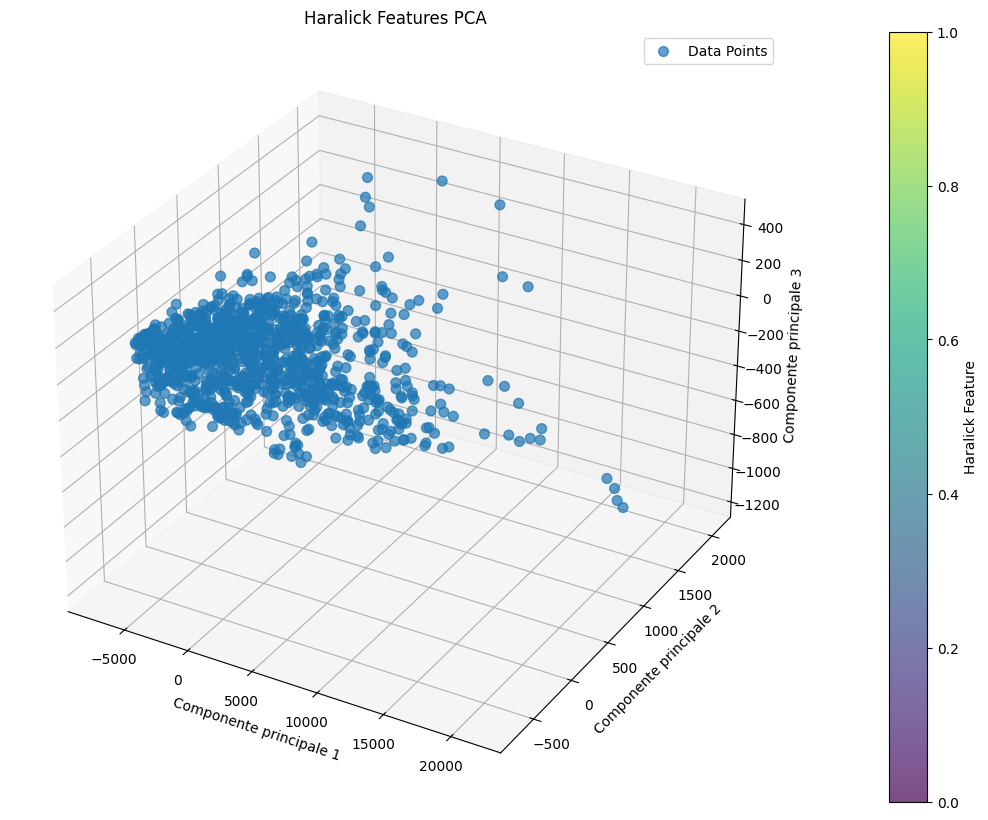

In [5]:
pca_3d = PCA(n_components=3, random_state=42)

haralick_data_for_pca = np.array(df["haralick"].tolist())

X_pca_3d = pca_3d.fit_transform(haralick_data_for_pca)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                           s=50, alpha=0.7, label='Data Points')

ax.set_title('Haralick Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Haralick Feature')

ax.legend()
plt.show()

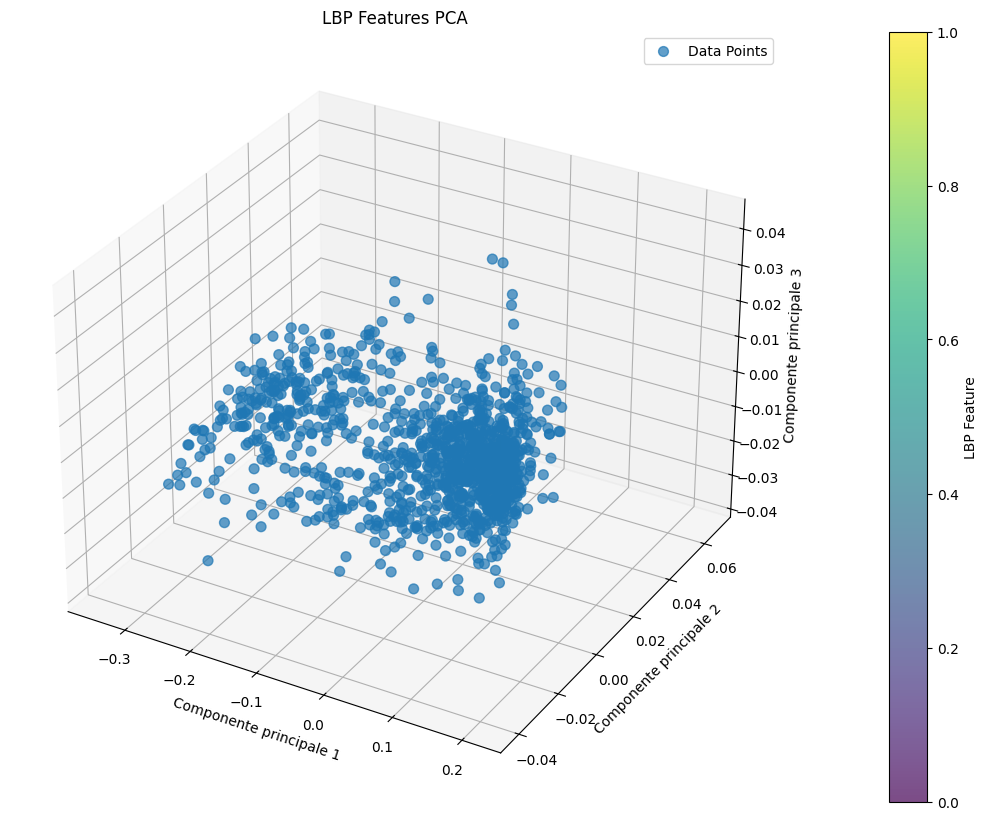

In [6]:
pca_3d = PCA(n_components=3, random_state=42)

lbp_data_for_pca = np.array(df["lbp_hist"].tolist())

X_pca_3d = pca_3d.fit_transform(lbp_data_for_pca)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, label='Data Points')

ax.set_title('LBP Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('LBP Feature')

ax.legend()
plt.show()

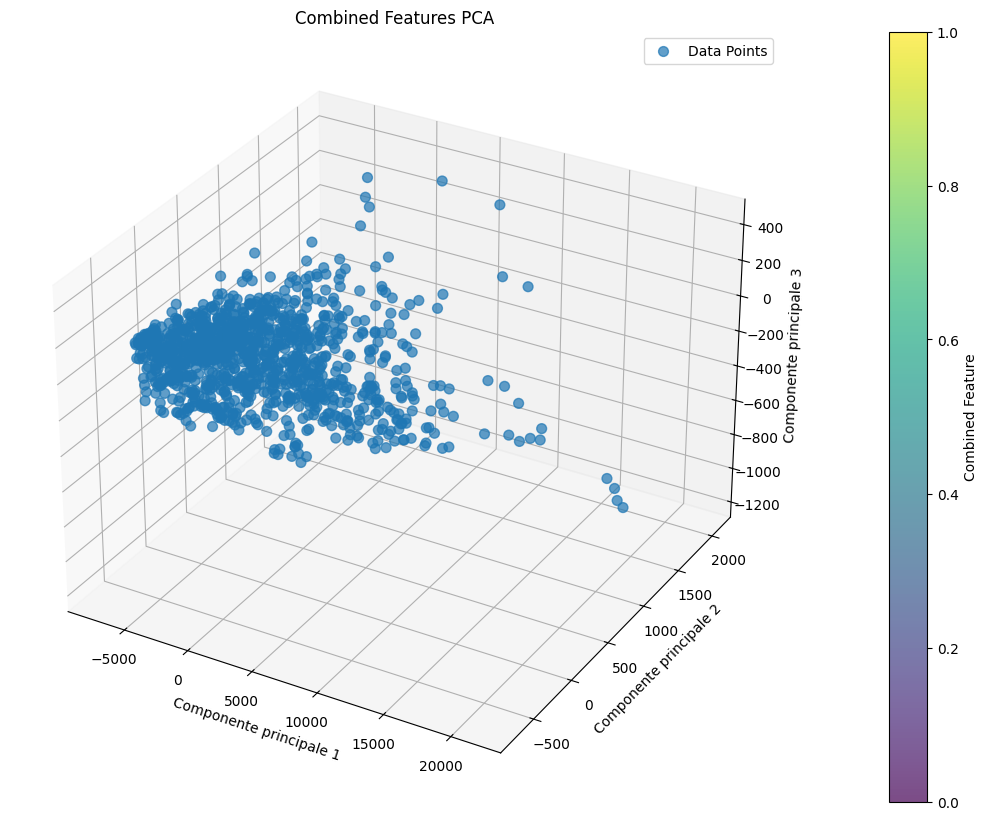

In [7]:
pca_3d = PCA(n_components=3, random_state=42)

combined_features_for_pca = np.concatenate((lbp_data_for_pca, haralick_data_for_pca), axis=1)

X_pca_3d = pca_3d.fit_transform(combined_features_for_pca)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, label='Data Points')

ax.set_title('Combined Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Combined Feature')

ax.legend()
plt.show()

# Supervised Learning

Per quanto riguarda la parte supervisionata utilizzerò un modello di Logistic Regression multi-classe

In [8]:
df['true_labels'] = true_labels
df

,lbp_hist,haralick,true_labels
0,"[0.06689453125, 0.02783203125, 0.019775390625,...","[0.001117270910100151, 131.45659722222217, 0.5...",0
1,"[0.059326171875, 0.027587890625, 0.01513671875...","[0.0007850760385172585, 70.01736111111106, 0.8...",0
2,"[0.06591796875, 0.027099609375, 0.024658203125...","[0.001424891788312547, 103.2207341269841, 0.49...",0
3,"[0.05615234375, 0.02783203125, 0.01806640625, ...","[0.0003528321050642482, 241.24925595238074, 0....",0
4,"[0.063720703125, 0.02490234375, 0.0205078125, ...","[0.0010161146345112116, 105.39732142857137, 0....",0
...,...,...,...
1118,"[0.057373046875, 0.013671875, 0.009521484375, ...","[0.0005564671615173847, 103.90550595238085, 0....",7
1119,"[0.0419921875, 0.017578125, 0.010986328125, 0....","[0.000379743549618922, 288.4397321428569, 0.89...",7
1120,"[0.05078125, 0.016845703125, 0.01708984375, 0....","[0.00041305222899344954, 232.13715277777757, 0...",7
1121,"[0.06494140625, 0.016845703125, 0.01416015625,...","[0.0011016161383534894, 41.27281746031743, 0.9...",7


Ora che abbiamo il dataframe contenente le features e le etichette di ground truth, possiamo procedere con la sua visualizzazione.

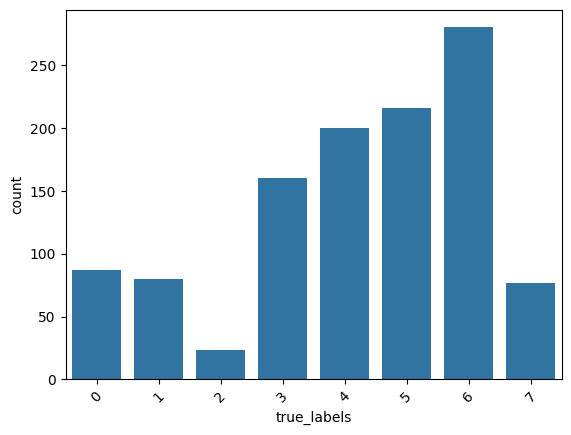

In [9]:
sns.countplot(x='true_labels', data=df)
plt.xticks(rotation=45)
plt.show()

In [10]:

features = combined_features_for_pca
X_train, X_test, y_train, y_test = train_test_split(features, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)

we can’t forget to scale our data. This is important because it help us to balance the impact of all variables on the distance calculation and can help to improve the performance of the algorithm

In [11]:
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.transform(X_test)

In [12]:
def logistic_model(C, solver_):
    logistic_regression_model = LogisticRegression(random_state=42, solver=solver_, n_jobs=1, C=C, max_iter=5000)
    return logistic_regression_model

Text(0.5, 1.0, 'Beans Accuracy')

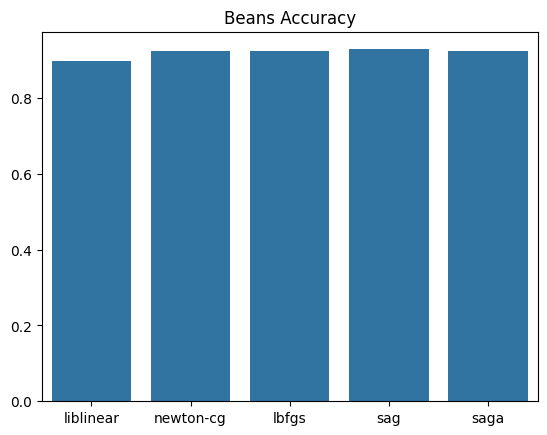

In [13]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params = []

for i in solver_list:
        try:
            model = logistic_model(10, i)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            params.append(i)
            accuracy = accuracy_score(y_test, predictions)
            scores.append(accuracy)
        except:
            print(f"Solver {i} ha generato un errore/warning: {e}")


sns.barplot(x=params, y=scores).set_title('Beans Accuracy')


In [14]:
print(f"Numero di classi uniche in y_train: {len(np.unique(y_train))}")
print(f"Classi uniche: {np.unique(y_train)}")

solver_accuracy = []
print("Scores ottenuti:")
for solver_name, score_val in zip(params, scores): # Assumendo che params e scores siano le tue liste
    print(f"  Solver: {solver_name}, Accuracy: {score_val:.6f}") # Stampa con più decimali
    solver_accuracy.append((solver_name, score_val))


Numero di classi uniche in y_train: 8
Classi uniche: [0 1 2 3 4 5 6 7]
Scores ottenuti:
  Solver: liblinear, Accuracy: 0.897778
  Solver: newton-cg, Accuracy: 0.924444
  Solver: lbfgs, Accuracy: 0.924444
  Solver: sag, Accuracy: 0.928889
  Solver: saga, Accuracy: 0.924444


Best solver: sag, Accuracy: 0.928889


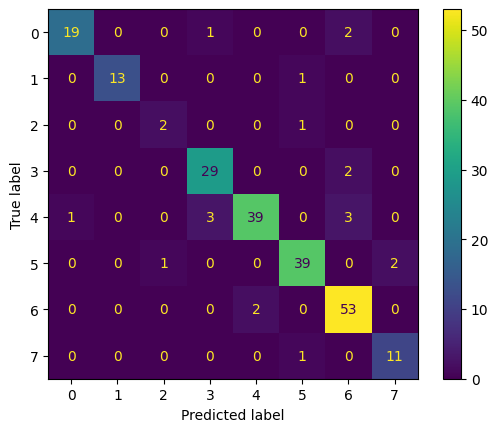

In [15]:
solver = max(solver_accuracy, key=lambda x: x[1])
print(f"Best solver: {solver[0]}, Accuracy: {solver[1]:.6f}")
model = logistic_model(1, solver[0])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [16]:
# 1. Generate the list of feature names
# These must match the order and number of features used to train the model.
n_lbp_features = lbp_data_for_pca.shape[1] # Number of LBP features
n_haralick_features = haralick_data_for_pca.shape[1] # Number of Haralick features

feature_names_lbp = [f'LBP_{i}' for i in range(n_lbp_features)]
feature_names_haralick = [f'Haralick_{i}' for i in range(n_haralick_features)]
all_feature_names = feature_names_lbp + feature_names_haralick # This is the 'features' list


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        22
           1       1.00      0.93      0.96        14
           2       0.67      0.67      0.67         3
           3       0.88      0.94      0.91        31
           4       0.95      0.85      0.90        46
           5       0.93      0.93      0.93        42
           6       0.88      0.96      0.92        55
           7       0.85      0.92      0.88        12

    accuracy                           0.91       225
   macro avg       0.89      0.88      0.88       225
weighted avg       0.91      0.91      0.91       225



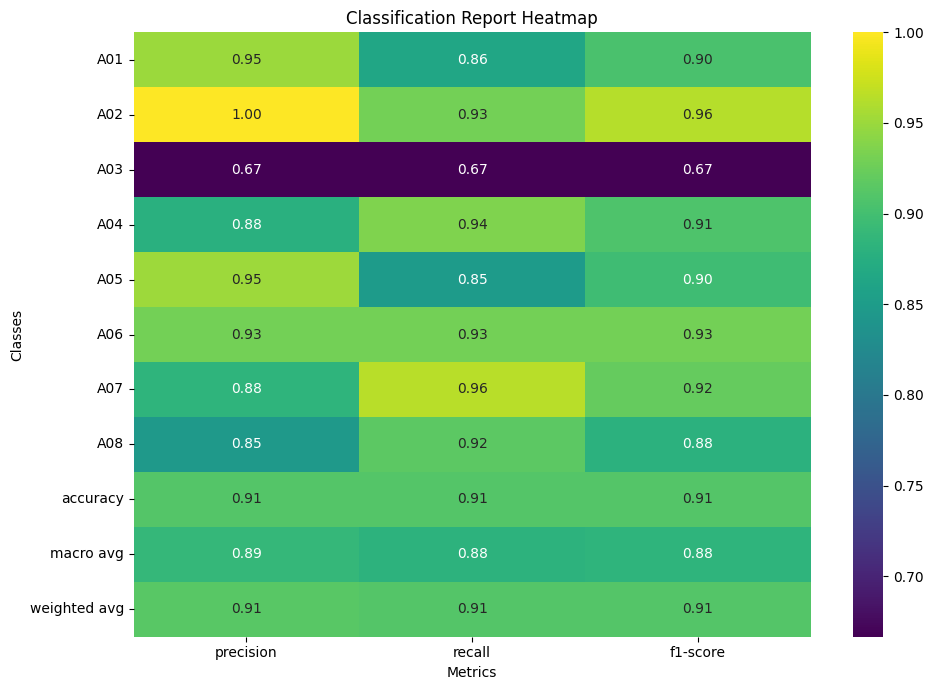

In [17]:
# Report di Classificazione
report = classification_report(y_test, predictions) # Ensure y_test and predictions are defined
print("\nClassification Report:")
print(report)

class_labels_for_report = [f"A0{i+1}" for i in sorted(np.unique(y_test))] # Assuming y_test is 0-7 for labels 1-8

report_dict = classification_report(y_test, predictions, output_dict=True, target_names=class_labels_for_report)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T # .iloc[:-1, :] esclude 'accuracy', .T traspone

# Filtriamo per visualizzare solo precision, recall, f1-score
metrics_to_plot = ['precision', 'recall', 'f1-score']
report_df_filtered = report_df[metrics_to_plot]


plt.figure(figsize=(10, 7))
sns.heatmap(report_df_filtered, annot=True, fmt=".2f", cmap="viridis")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()


Il modello ha 8 set di coefficienti (uno per classe vs resto).
Mostrando la magnitudine assoluta media dei coefficienti attraverso le classi:

Feature Importance (Coefficients):
        Feature  Average Absolute Importance
0         LBP_0                     0.806653
40       LBP_40                     0.767984
39       LBP_39                     0.545333
1         LBP_1                     0.525021
8         LBP_8                     0.523586
70  Haralick_28                     0.482739
9         LBP_9                     0.460122
34       LBP_34                     0.448029
38       LBP_38                     0.447504
83  Haralick_41                     0.444692
82  Haralick_40                     0.423070
6         LBP_6                     0.416446
31       LBP_31                     0.416314
44   Haralick_2                     0.403505
12       LBP_12                     0.392587


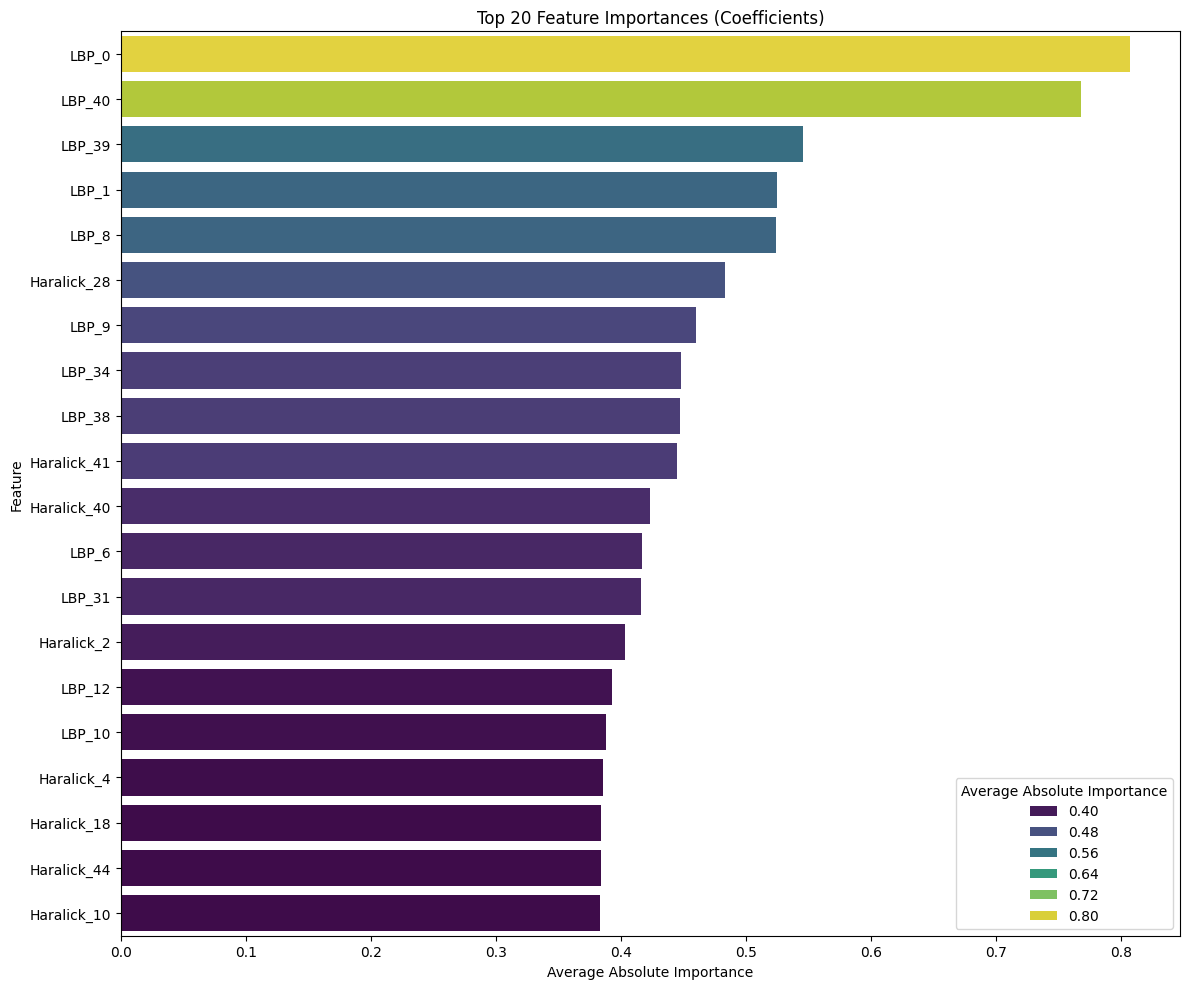

In [18]:

# 3. Importanza delle Feature
importance_col_name_for_plot = "" # To store the column name for plotting

if hasattr(model, 'coef_'):
    coefficients = model.coef_

    if len(all_feature_names) != coefficients.shape[1]:
        print(f"Error: Mismatch! Number of feature names ({len(all_feature_names)}) "
              f"does not match number of model coefficients ({coefficients.shape[1]}).")
        print("Ensure 'all_feature_names' accurately reflects the features the model was trained on.")
        feature_importance_df = None # Skip plotting if mismatch
    else:
        if coefficients.shape[0] == 1: 
            # Binary classification or model with a single set of coefficients
            feature_importance_values = coefficients[0]
            feature_importance_df = pd.DataFrame({
                'Feature': all_feature_names, 
                'Importance': feature_importance_values
            })
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            importance_col_name_for_plot = 'Importance'
        else: 
            # Multi-class classification (e.g., Logistic Regression with multi_class='ovr' or 'multinomial')
            print(f"\nIl modello ha {coefficients.shape[0]} set di coefficienti (uno per classe vs resto).")
            print("Mostrando la magnitudine assoluta media dei coefficienti attraverso le classi:")
            
            avg_abs_coeffs = np.mean(np.abs(coefficients), axis=0)
            feature_importance_df = pd.DataFrame({
                'Feature': all_feature_names, 
                'Average Absolute Importance': avg_abs_coeffs
            })
            feature_importance_df = feature_importance_df.sort_values(by='Average Absolute Importance', ascending=False)
            importance_col_name_for_plot = 'Average Absolute Importance'

        if feature_importance_df is not None:
            print("\nFeature Importance (Coefficients):")
            print(feature_importance_df.head(15)) # Display top 15 features

            plt.figure(figsize=(12, 10)) # Adjusted figure size
            top_n_to_display = 20 # Show top N features in the plot
            sns.barplot(
                x=importance_col_name_for_plot, 
                y='Feature', 
                data=feature_importance_df.head(top_n_to_display), 
                palette='viridis',
                hue=importance_col_name_for_plot, # Retained from your original code
                dodge=False # Add if hue makes bars too thin or grouped unnecessarily
            )
            plt.title(f'Top {top_n_to_display} Feature Importances (Coefficients)')
            plt.tight_layout()
            plt.show()

elif hasattr(model, 'feature_importances_'):
    # For models like Decision Trees, Random Forest, Gradient Boosting
    importances = model.feature_importances_
    if len(all_feature_names) != len(importances):
        print(f"Error: Mismatch! Number of feature names ({len(all_feature_names)}) "
              f"does not match number of model importances ({len(importances)}).")
    else:
        feature_importance_df = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        })
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        importance_col_name_for_plot = 'Importance'

        print("\nFeature Importance (from feature_importances_):")
        print(feature_importance_df.head(15)) # Display top 15 features

        plt.figure(figsize=(12, 10)) # Adjusted figure size
        top_n_to_display = 20 # Show top N features in the plot
        sns.barplot(
            x=importance_col_name_for_plot, 
            y='Feature', 
            data=feature_importance_df.head(top_n_to_display), 
            palette='viridis',
            hue=importance_col_name_for_plot, # Retained from your original code
            dodge=False
        )
        plt.title(f'Top {top_n_to_display} Feature Importances (from _feature_importances_)')
        plt.tight_layout()
        plt.show()
else:
    print("\nIl modello selezionato non ha l'attributo 'coef_' né 'feature_importances_'. "
          "L'importanza delle feature non può essere estratta direttamente per questo tipo di modello.")


# Modello nullo

Accuracy: 0.2493321460373998


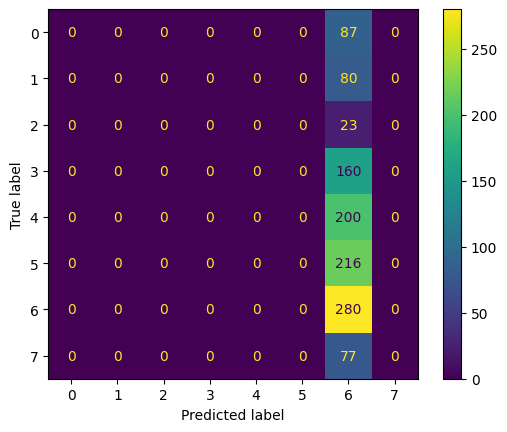

In [25]:

null_model_y = np.full(len(true_labels), 6)
cm = metrics.confusion_matrix(true_labels, null_model_y)
print("Accuracy:", metrics.accuracy_score(true_labels, null_model_y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7])
disp.plot()
plt.show()

## Fonti
- https://github.com/sbianco78/UnsupervisedPlanktonLearning
- LBP: https://scikit-image.org/docs/0.24.x/auto_examples/features_detection/plot_local_binary_pattern.html
- LBP: https://arxiv.org/html/2407.18665v1
- Haralick: https://www.haralick.org/journals/TexturalFeatures.pdf
- PCA: https://www.ibm.com/it-it/think/topics/principal-component-analysis
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Logistic Regression: https://danhergir.medium.com/implementing-multi-class-logistic-regression-with-scikit-learn-53d919b72c13